In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import torch
import torch.nn.functional as F
import tqdm
import random

from torch import nn
from einops import rearrange, repeat, pack, unpack
from einops.layers.torch import Rearrange
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder

from TimeMAE.args import args, Test_data, Train_data_all, Train_data, Test_data
from TimeMAE.model.TimeMAE import TimeMAE
from TimeMAE.dataset import Dataset
import torch.utils.data as Data

TRAIN_DATA shape: torch.Size([28928, 256, 1])
data loaded
Namespace(save_path='exp/epilepsy/test', dataset='har', UCR_folder='PhonemeSpectra', data_path='TimeMAE/data/ECG/', device='cpu', train_batch_size=128, test_batch_size=128, d_model=64, dropout=0.2, attn_heads=4, eval_per_steps=226, enable_res_parameter=1, layers=8, alpha=5.0, beta=1.0, momentum=0.99, vocab_size=192, wave_length=8, mask_ratio=0.6, reg_layers=4, lr=0.001, lr_decay_rate=1.0, lr_decay_steps=226, weight_decay=0.01, num_epoch_pretrain=1, num_epoch=1, load_pretrained_model=1, f='/Users/jamildhanani/Library/Jupyter/runtime/kernel-c92f173f-e27a-453e-ad77-341d8deb0a8d.json', num_class=3)


In [3]:
train_dataset = Dataset(device=args.device, mode='pretrain', data=Train_data_all, wave_len=args.wave_length)
train_loader = Data.DataLoader(train_dataset, batch_size=args.train_batch_size, shuffle=True)
args.data_shape = train_dataset.shape()

test_dataset = Dataset(device=args.device, mode='test', data=Test_data, wave_len=args.wave_length)
test_loader = Data.DataLoader(test_dataset, batch_size=args.test_batch_size)

In [4]:
os.listdir('TimeMAE/exp/epilepsy/test')

['args.json',
 'result.txt',
 'model.pkl',
 'linear_result.txt',
 'pretrain_model.pkl',
 'pretrain_result.txt']

In [5]:
pretrain_model = torch.load('TimeMAE/exp/epilepsy/test/pretrain_model.pkl')

In [6]:
args

Namespace(save_path='exp/epilepsy/test', dataset='har', UCR_folder='PhonemeSpectra', data_path='TimeMAE/data/ECG/', device='cpu', train_batch_size=128, test_batch_size=128, d_model=64, dropout=0.2, attn_heads=4, eval_per_steps=226, enable_res_parameter=1, layers=8, alpha=5.0, beta=1.0, momentum=0.99, vocab_size=192, wave_length=8, mask_ratio=0.6, reg_layers=4, lr=0.001, lr_decay_rate=1.0, lr_decay_steps=226, weight_decay=0.01, num_epoch_pretrain=1, num_epoch=1, load_pretrained_model=1, f='/Users/jamildhanani/Library/Jupyter/runtime/kernel-c92f173f-e27a-453e-ad77-341d8deb0a8d.json', num_class=3, data_shape=(256, 1))

In [7]:
model = TimeMAE(args)

32


In [8]:
model.load_state_dict(pretrain_model)

<All keys matched successfully>

In [9]:
_ = model.eval()

torch.Size([128, 256, 1])


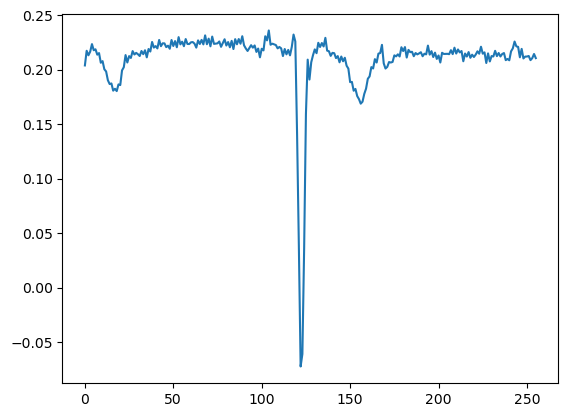

In [10]:
for seqs, labels in test_loader:
    print(seqs.shape)
    plt.plot(seqs[0, :, 0])
    with torch.no_grad():
        [rep_mask, rep_mask_prediction], [token_prediction_prob, tokens] = model.pretrain_forward(seqs)
    break

In [11]:
first_mask = rearrange(rep_mask[0], 'np p -> (np p)')

In [12]:
tokens.shape

torch.Size([128, 19])

In [13]:
print(tokens[0])
print(token_prediction_prob[0].argmax(axis=1))

tensor([  4, 145,  45,  77, 187, 109, 158, 163, 149,  78,  16,  69, 103, 188,
        183,  49,   8,  87, 145])
tensor([82, 54, 82, 82, 82, 82, 82, 82, 82, 54, 82, 82, 82, 82, 82, 82, 82, 82,
        82])


In [14]:
torch.sum(torch.argmax(token_prediction_prob, dim=-1) == tokens)

tensor(18)